# PCA analysis of predictiveness of DEG for gender

In [1]:
#load required packages
import functools
import numpy as np
import pandas as pd
from plotnine import *
from scipy.stats import linregress
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from warnings import filterwarnings
from matplotlib.cbook import mplDeprecation

In [2]:
filterwarnings("ignore",category=mplDeprecation)
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')

## Configuration and functions

In [3]:
feature = 'genes'
config = {
    'deg_file': '../../_m/%s/diffExpr_maleVfemale_full.txt' % feature,
    'res_file': '../../_m/%s/residualized_expression.tsv' % feature,
    'pheno_file': '/ceph/projects/v3_phase3_paper/inputs/phenotypes/_m/caudate_phenotypes.csv',
    'deg_autosomal': '../../metrics_summary/_m/autosomal_DEG.csv',
}

In [4]:
@functools.lru_cache()
def get_deg():
    ''' Take DE genes obtained from limma-voom pipeline.
    '''
    deg = pd.read_csv(config['deg_file'], sep='\t').sort_values('adj.P.Val')
    return deg[(deg['adj.P.Val'] < 0.05)]


@functools.lru_cache()
def get_autosomal_deg():
    ''' Take autosomal only DE genes.'''
    return pd.read_csv(config['deg_autosomal'], index_col=0).sort_values('adj.P.Val')


@functools.lru_cache()
def get_residualized():
    '''Load residualization file.
    '''
    return pd.read_csv(config['res_file'], sep='\t', index_col=0).transpose()#.drop(['R12963', 'R12973', 'R13480'])


@functools.lru_cache()
def get_deg_res_df(num):
    de_df = get_deg()
    res_df = get_residualized()
    if num == 0:
        geneList = np.array(de_df.index)
    else:
        geneList = np.array(de_df.head(num).index)
    return res_df[geneList]


@functools.lru_cache()
def get_autosomal_deg_res_df(num):
    de_df = get_autosomal_deg()
    res_df = get_residualized()
    if num == 0:
        geneList = np.array(de_df.index)
    else:
        geneList = np.array(de_df.head(num).index)
    return res_df[geneList]


@functools.lru_cache()
def get_pheno_data():
    return pd.read_csv(config['pheno_file'], index_col=0)

In [5]:
def get_explained_variance(df):
    x = StandardScaler().fit_transform(df)
    pca = PCA(n_components=2).fit(x)
    pc1 = pca.explained_variance_ratio_[0]
    pc2 = pca.explained_variance_ratio_[1]
    print("Explained Variance\nPC1:\t%0.5f\nPC2:\t%0.5f" % (pc1, pc2))
    
    
def cal_pca(df):
    x = StandardScaler().fit_transform(df)
    pca = PCA(n_components=2).fit_transform(x)
    return pd.DataFrame(data=pca, columns=['PC1', 'PC2'], index=df.index)


def get_pca_df(num, deg_fnc):
    '''
    num: refers to how many genes we want to include
    if 0, look at all genes, if not 0, look at only those specified genes
    new_pheno: this is the correct size of samples using the the first two columns of residualized expression
      - the residualized expression data frame, has the correct samples (dropping qSV samples included in pheno)
      - output new_pheno shape row numbers should be the same as res_df row numbers
    '''
    expr_res = deg_fnc(num)
    pheno_df = get_pheno_data()
    new_pheno = pheno_df.merge(expr_res.iloc[:, 0:1], right_index=True, # Generate pheno data frame with correct samples
                               left_index=True).drop(expr_res.iloc[:, 0:1].columns, axis=1)
    principalDf = cal_pca(expr_res)
    get_explained_variance(expr_res)
    return pd.concat([principalDf, new_pheno], axis = 1)


def calculate_corr(xx, yy):
    '''This calculates R^2 correlation via linear regression:
         - used to calculate relationship between 2 arrays 
         - the arrays are principal components 1 or 2 (PC1, PC2) AND gender
         - calculated on a scale of 0 to 1 (with 0 being no correlation)
        Inputs: 
          x: array of Gender (converted to binary output)
          y: array of PC
        Outputs: 
          1. r2
          2. p-value, two-sided test 
            - whose null hypothesis is that two sets of data are uncorrelated
          3. slope (beta): directory of correlations
    '''
    slope, intercept, r_value, p_value, std_err = linregress(xx, yy)
    return slope, r_value, p_value

    
def corr_annotation(dft):
    xx = dft.Sex.cat.codes
    yy = dft.PC1
    zz = dft.PC2
    slope1, r_value1, p_value1 = calculate_corr(xx, yy)
    slope2, r_value2, p_value2 = calculate_corr(xx, zz)
    label = 'PC1 R2: %.2f\nP-value: %.2e' % (r_value1**2, p_value1)
    print('PC2 R2: %.4f Pval: %.3e' % (r_value2**2, p_value2))
    return label


In [6]:
def plot_corr_impl(num, deg_fnc):
    pca_df = get_pca_df(num, deg_fnc)
    pca_df['Sex'] = pca_df.Sex.astype('category').cat.rename_categories({'F': 'Female', 'M': 'Male'})
    title = '\n'.join([corr_annotation(pca_df)])
    pp = ggplot(pca_df, aes(x='PC1', y='PC2', color='Sex'))\
    + geom_point(alpha=0.75, size=4)\
    + theme_matplotlib()\
    + theme(axis_text_x=element_blank(), 
            axis_text_y=element_text(size=18), 
            axis_title=element_text(size=21), 
            plot_title=element_text(size=22),
            legend_text=element_text(size=16), 
            legend_title=element_blank(), 
            legend_position="bottom")
    pp += ggtitle(title)
    return pp


def plot_corr(num, deg_fnc):
    return plot_corr_impl(num, deg_fnc)


def save_plot(p, fn, width=7, height=7):
    '''Save plot as svg, png, and pdf with specific label and dimension.'''
    for ext in ['.svg', '.png', '.pdf']:
        p.save(fn+ext, width=width, height=height)


## All DEG

Explained Variance
PC1:	0.16797
PC2:	0.06981
PC2 R2: 0.1075 Pval: 3.185e-11


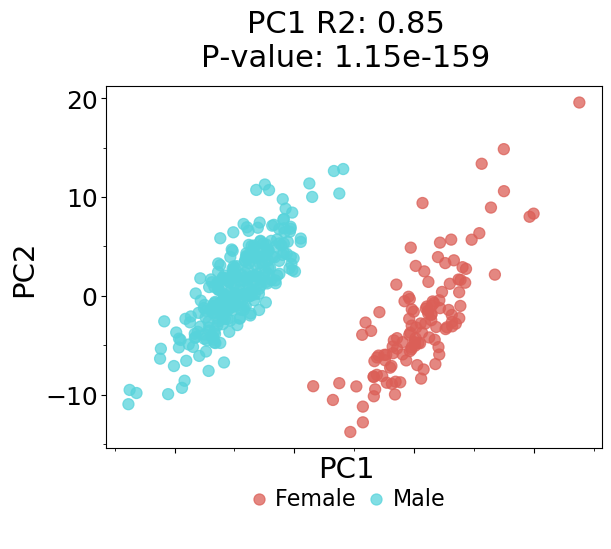

<ggplot: (8746829004373)>

In [7]:
pp = plot_corr(0, get_deg_res_df)
pp

Explained Variance
PC1:	0.93462
PC2:	0.01190
PC2 R2: 0.0030 Pval: 2.835e-01


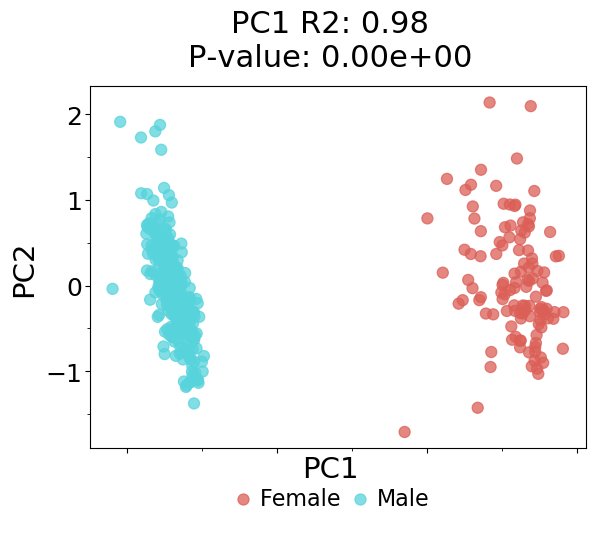

<ggplot: (8746828238538)>

In [8]:
qq = plot_corr(30, get_deg_res_df)
qq

Explained Variance
PC1:	0.97582
PC2:	0.01094
PC2 R2: 0.0001 Pval: 8.354e-01


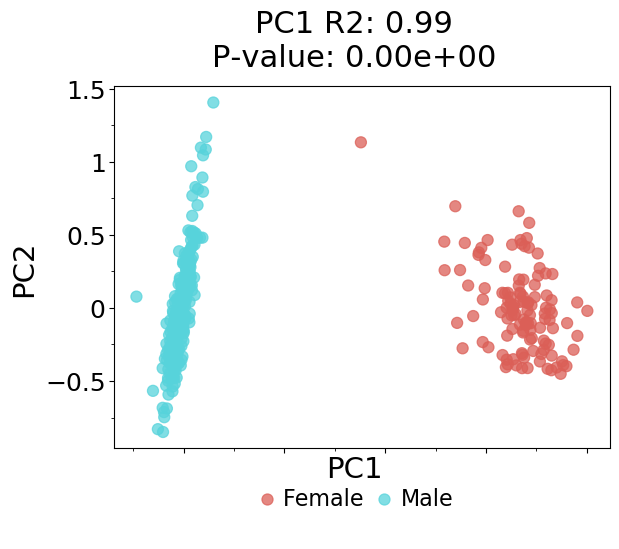

<ggplot: (8746828233933)>

In [9]:
ww = plot_corr(10, get_deg_res_df)
ww

In [12]:
save_plot(pp, 'deg_pca_all')
save_plot(qq, 'deg_pca_top30')
save_plot(ww, 'deg_pca_top10')

## XIST correlation

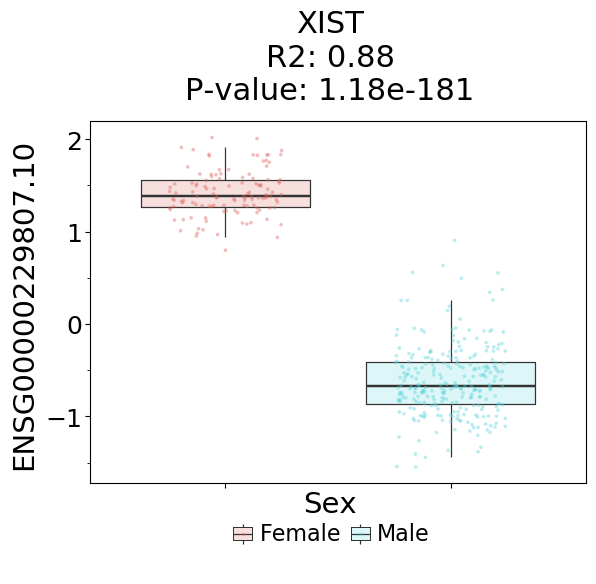

<ggplot: (8746828148490)>

In [10]:
expr_res = get_deg_res_df(5)
pheno_df = get_pheno_data()
dft = pheno_df.merge(expr_res, right_index=True, left_index=True)
dft['Sex'] = dft.Sex.astype('category').cat.rename_categories({'F': 'Female', 'M': 'Male'})

xx = dft.Sex.cat.codes
yy = dft['ENSG00000229807.10'].values
slope, intercept, r_value, p_value, std_err = linregress(xx, yy)

label = 'XIST\nR2: %.2f\nP-value: %.2e' % (r_value**2, p_value)

title = label
xist = ggplot(dft, aes(x='Sex', y='ENSG00000229807.10', fill='Sex'))\
+ geom_boxplot(alpha=0.2, outlier_alpha=0)\
+ geom_jitter(width=0.25, stroke=0, alpha=0.4)\
+ theme_matplotlib()\
+ theme(axis_text_x=element_blank(), 
        axis_text_y=element_text(size=18), 
        axis_title=element_text(size=21), 
        plot_title=element_text(size=22),
        legend_text=element_text(size=16), 
        legend_title=element_blank(), 
        legend_position="bottom")
xist += ggtitle(title)
xist

In [ ]:
save_plot(xist, 'topX_xist_correlation')

## USP9Y correlation

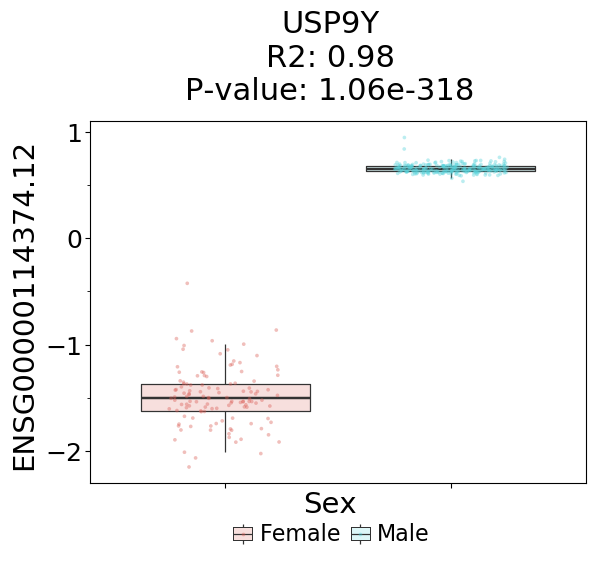

<ggplot: (8746828148523)>

In [11]:
expr_res = get_deg_res_df(5)
pheno_df = get_pheno_data()
dft = pheno_df.merge(expr_res, right_index=True, left_index=True)
dft['Sex'] = dft.Sex.astype('category').cat.rename_categories({'F': 'Female', 'M': 'Male'})

xx = dft.Sex.cat.codes
yy = dft['ENSG00000114374.12'].values
slope, intercept, r_value, p_value, std_err = linregress(xx, yy)

label = 'USP9Y\nR2: %.2f\nP-value: %.2e' % (r_value**2, p_value)

title = label
usp9y = ggplot(dft, aes(x='Sex', y='ENSG00000114374.12', fill='Sex'))\
+ geom_boxplot(alpha=0.2, outlier_alpha=0)\
+ geom_jitter(width=0.25, stroke=0, alpha=0.4)\
+ theme_matplotlib()\
+ theme(axis_text_x=element_blank(), 
        axis_text_y=element_text(size=18), 
        axis_title=element_text(size=21), 
        plot_title=element_text(size=22),
        legend_text=element_text(size=16), 
        legend_title=element_blank(), 
        legend_position="bottom")
usp9y += ggtitle(title)
usp9y

In [ ]:
save_plot(usp9y, 'topY_usp9y_correlation')

## Autosomal DEG

Explained Variance
PC1:	0.12289
PC2:	0.04101
PC2 R2: 0.0008 Pval: 5.679e-01


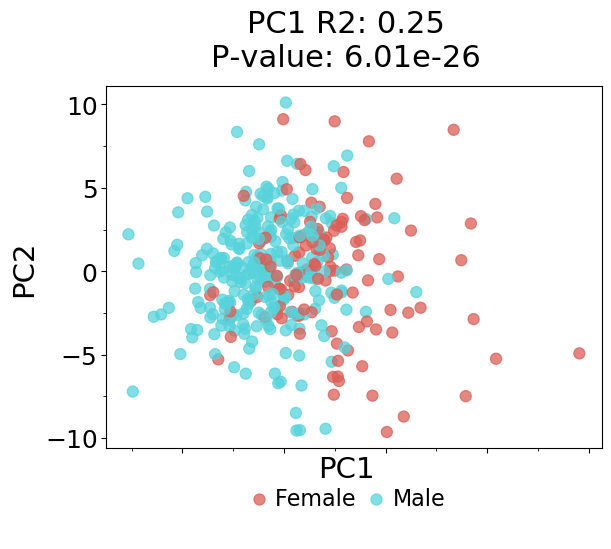

<ggplot: (8746828147390)>

In [12]:
pp = plot_corr(0, get_autosomal_deg_res_df)
pp

Explained Variance
PC1:	0.19578
PC2:	0.08940
PC2 R2: 0.1151 Pval: 5.873e-12


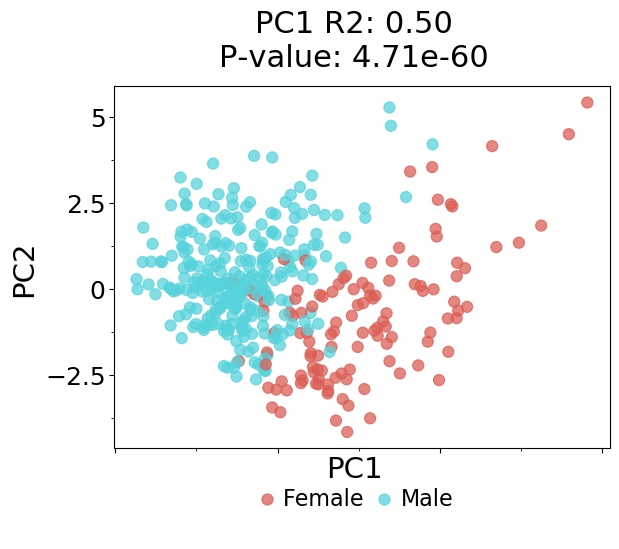

<ggplot: (8746828103617)>

In [13]:
qq = plot_corr(30, get_autosomal_deg_res_df)
qq

Explained Variance
PC1:	0.37727
PC2:	0.15677
PC2 R2: 0.1520 Pval: 1.321e-15


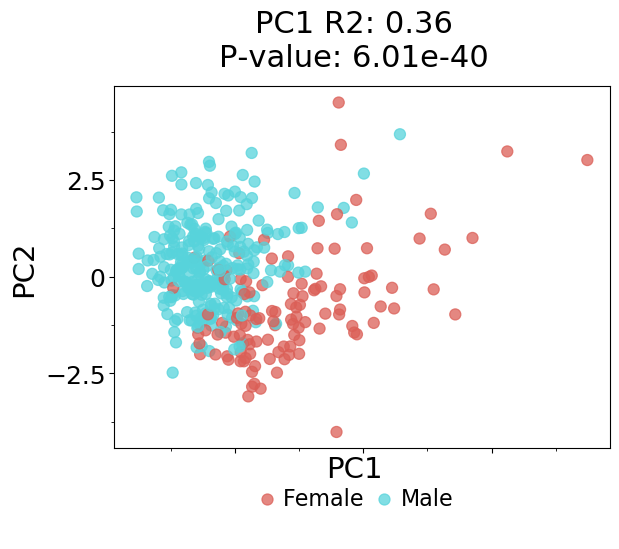

<ggplot: (8746828022056)>
Explained Variance
PC1:	0.26849
PC2:	0.12449
PC2 R2: 0.1196 Pval: 2.120e-12


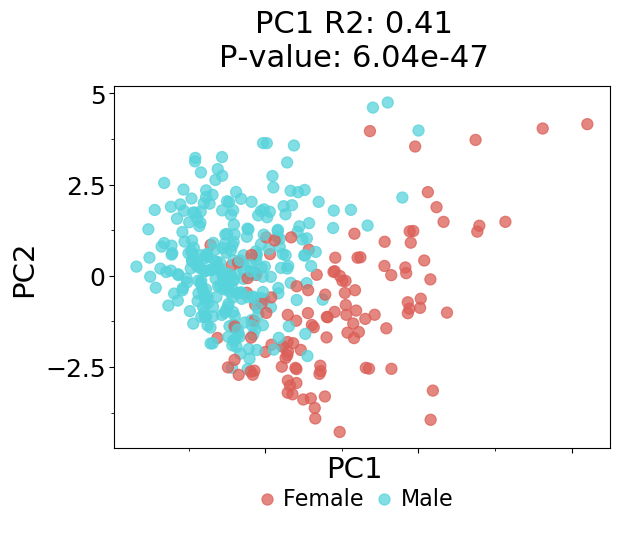

<ggplot: (8746828020170)>
Explained Variance
PC1:	0.19578
PC2:	0.08940
PC2 R2: 0.1151 Pval: 5.873e-12


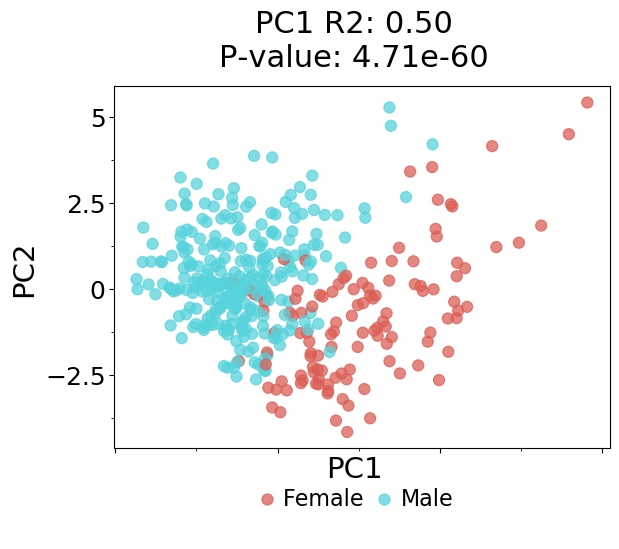

<ggplot: (8746828022173)>
Explained Variance
PC1:	0.17072
PC2:	0.07563
PC2 R2: 0.0775 Pval: 2.242e-08


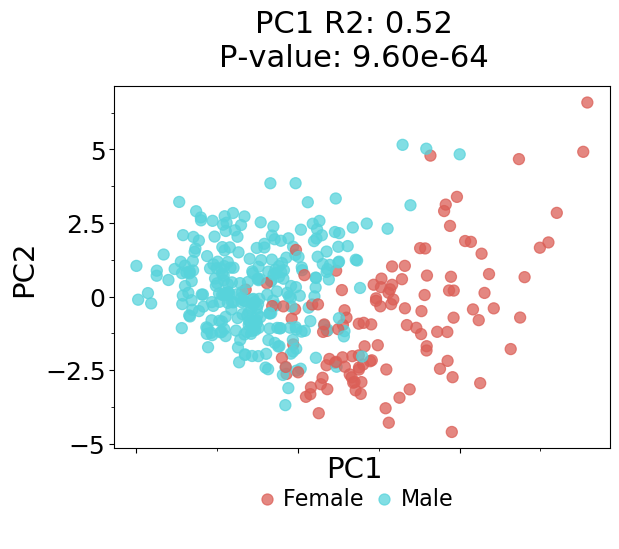

<ggplot: (8746827984671)>
Explained Variance
PC1:	0.14898
PC2:	0.06348
PC2 R2: 0.0918 Pval: 9.986e-10


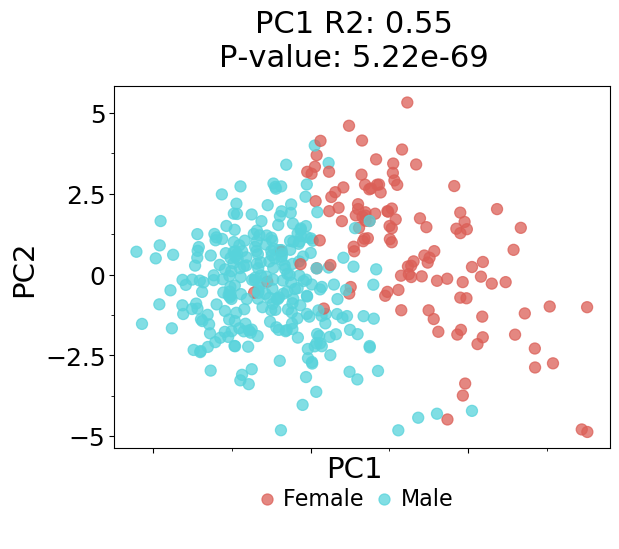

<ggplot: (8746827360582)>
Explained Variance
PC1:	0.13535
PC2:	0.05804
PC2 R2: 0.0481 Pval: 1.248e-05


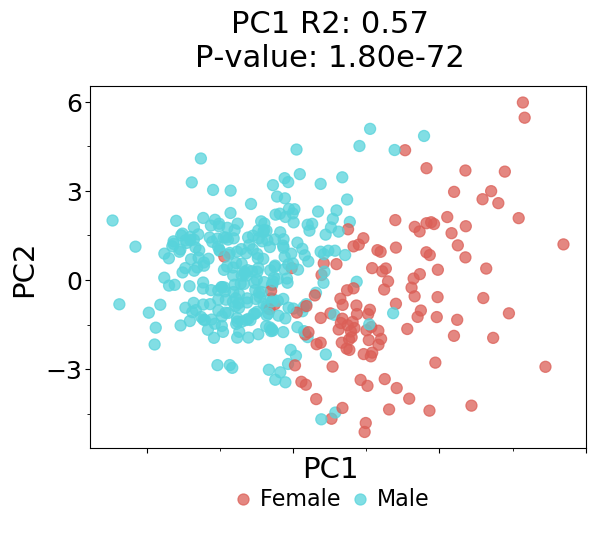

<ggplot: (8746827403313)>
Explained Variance
PC1:	0.12764
PC2:	0.05513
PC2 R2: 0.0001 Pval: 8.670e-01


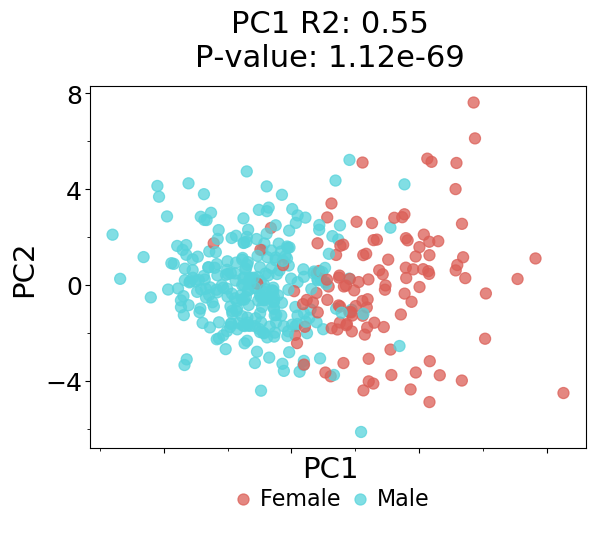

<ggplot: (8746827318468)>
Explained Variance
PC1:	0.12936
PC2:	0.05885
PC2 R2: 0.0631 Pval: 5.056e-07


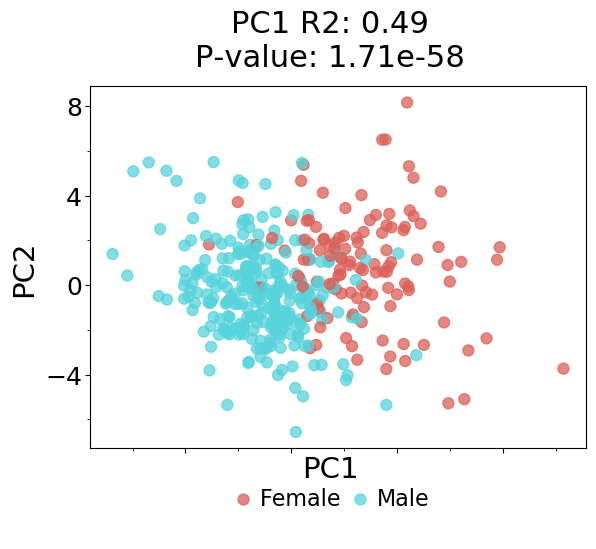

<ggplot: (8746827306641)>
Explained Variance
PC1:	0.12419
PC2:	0.05673
PC2 R2: 0.0651 Pval: 3.259e-07


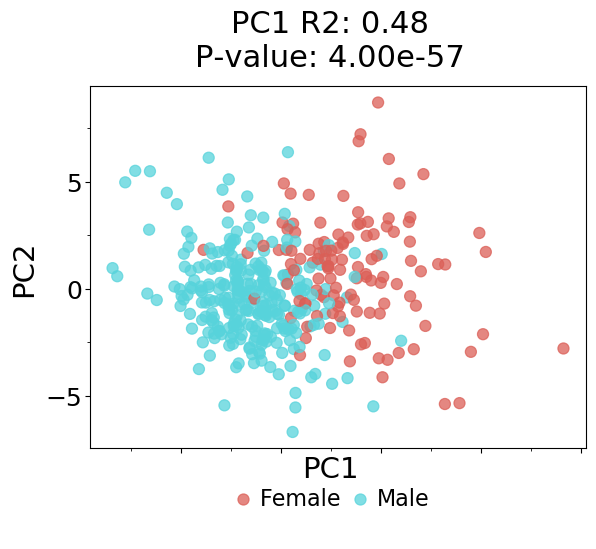

<ggplot: (8746827269373)>


In [14]:
for num in range(10, 100, 10):
    print(plot_corr(num, get_autosomal_deg_res_df))

Explained Variance
PC1:	0.13535
PC2:	0.05804
PC2 R2: 0.0481 Pval: 1.248e-05


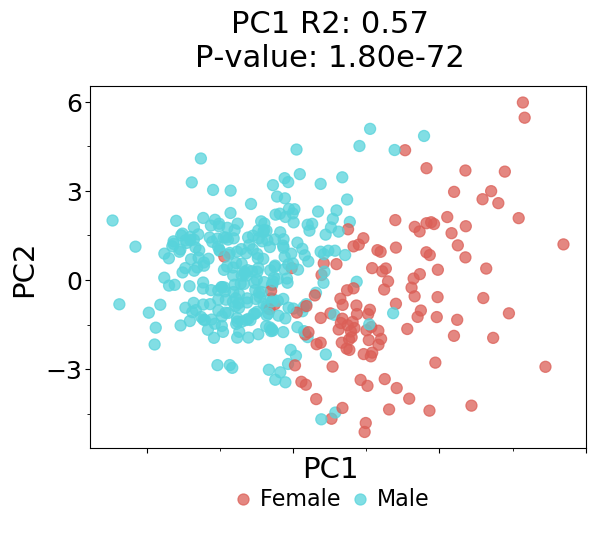

<ggplot: (8746827269238)>

In [15]:
ww = plot_corr(60, get_autosomal_deg_res_df)
ww

In [31]:
save_plot(pp, 'autosomal_deg_pca_all')
save_plot(qq, 'autosomal_deg_pca_top30')
save_plot(ww, 'autosomal_deg_pca_top60')